In [1]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import spearmanr
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database, drop_database
from utils import make_regression_array

In [2]:
retrain = False

In [3]:
sns.set_style('white')

small_size = 18
medium_size = 20
bigger_size = 22

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

In [4]:
with open('pg_credentials.p', 'rb') as f:
    pg_credentials = pickle.load(f)

In [5]:
host     = 'localhost'
db_name  = 'goodreads_db'
username = pg_credentials['username']
password = pg_credentials['password']
port = '5432'  # default port that postgres listens on
    
con = psycopg2.connect(database = db_name, user = username, host=host, password=password)

In [6]:
query = "SELECT * FROM works_withgenrelang"
all_data = pd.read_sql_query(query, con)

In [7]:
print(all_data.columns)

Index(['level_0', 'index', 'id', 'title', 'is_series', 'author', 'all_authors',
       'rating', 'nratings', 'nreviews', 'blurb', 'pubyear', 'language',
       'to_read', 'favs', 'dnf', 'comics', 'short_stories', 'ya', 'children',
       'winner', 'true_score', 'nprev', 'pub_date', 'author_annualviews',
       'author_lastname', 'pub_id', 'pub_ctype', 'pub_isbn', 'author_id',
       'author_canonical', 'title_id', 'title_storylen', 'title_graphic',
       'title_annualviews', 'debut_year', 'identifier_value_amazon',
       'identifier_value_goodreads', 'identifier_value_oclc',
       'identifier_value_bn', 'identifier_value_audible', 'genre0', 'genre1',
       'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8',
       'genre9', 'review_embed0', 'review_embed1', 'review_embed2',
       'review_embed3', 'review_embed4', 'review_embed5', 'review_embed6',
       'review_embed7', 'review_embed8', 'review_embed9'],
      dtype='object')


In [8]:
data, mask = make_regression_array(all_data)

0      -43.0
1      -44.0
3      -43.0
4      -39.0
5      -44.0
        ... 
4814   -50.0
4817   -48.0
4819   -47.0
4824   -42.0
4825   -41.0
Name: debut_year, Length: 2702, dtype: float64


/home/msimet/projects/victor_predictor/analysis/notebooks/utils.py:26: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  year_mask = (data['debut_year'].isna()) | (data['pub_date']>=datetime.date(2030, 1, 1)) | (data['pub_date'].isna())
/home/msimet/projects/victor_predictor/analysis/notebooks/utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['debut_year'][year_mask] = np.nan
/home/msimet/projects/victor_predictor/analysis/notebooks/utils.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [9]:
ymask = (all_data['pubyear'][mask] < 2018) & (all_data['pubyear'][mask] > 2008)
mask[mask][~ymask.values] = False
data = data[ymask]

In [10]:
correlations = []
for column in data.columns:
    correlations.append(spearmanr(data[column], data['true_score'])[1])

/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [11]:
print(np.array(data.columns)[np.argsort(correlations)])

['true_score' 'nprev' 'title_annualviews' 'author_annualviews' 'nratings'
 'genre6' 'genre2' 'dnf' 'genre1' 'ya' 'genre3' 'genre5' 'review_embed0'
 'to_read' 'genre0' 'favs' 'children' 'genre8' 'review_embed2' 'genre4'
 'is_series' 'nreviews' 'review_embed3' 'review_embed5' 'review_embed6'
 'genre9' 'genre7' 'review_embed7' 'review_embed1' 'rating'
 'review_embed4' 'review_embed8' 'review_embed9' 'years_since_debut'
 'pub_date' 'short_stories' 'title_graphic' 'comics']


In [12]:
print(np.array(correlations)[np.argsort(correlations)])

[0.00000000e+000 1.20706938e-100 1.18806088e-040 7.41875094e-029
 1.46844940e-024 5.15784623e-017 1.04987017e-014 4.60313689e-007
 5.09296298e-007 2.28078236e-006 5.83168346e-006 6.11918249e-005
 1.90086673e-004 2.14474801e-004 8.20960315e-004 1.80417310e-003
 1.87309766e-003 4.39758643e-003 9.24536455e-003 7.72651515e-002
 9.37552902e-002 1.14265891e-001 1.33375372e-001 1.40098132e-001
 2.26763538e-001 2.77235542e-001 2.81125697e-001 3.32946747e-001
 4.22860805e-001 4.81814953e-001 5.36519731e-001 6.21014926e-001
 7.33556703e-001 7.40007910e-001 9.36181565e-001             nan
             nan             nan]


In [13]:
if retrain:
    cols = [c for c, p in zip(data.columns, correlations) if p<1E-2]
    np.save('columns.npy', cols)
else:
    cols = np.load('columns.npy')

In [14]:
print(cols)

['nratings', 'to_read', 'favs', 'dnf', 'ya', 'children', 'true_score', 'nprev', 'author_annualviews', 'title_annualviews', 'genre0', 'genre1', 'genre2', 'genre3', 'genre5', 'genre6', 'genre8', 'review_embed0', 'review_embed2']


In [31]:
x_train = data.sample(frac=0.8, random_state=100)
x_test = data.drop(x_train.index)
data_train = x_train
data_test = x_test
x_train = x_train[cols]
x_test = x_test[cols]
y_train_continuous = x_train.pop("true_score")
y_test_continuous = x_test.pop("true_score")
thresh = 0
y_train = y_train_continuous > thresh
y_test = y_test_continuous > thresh
x_train_true = x_train[y_train==1]
x_train_false = x_train[y_train==0]

In [43]:
if retrain:
    yp_train_list = []
    yp_test_list = []
    model_list = []
    frac = 1.0*len(x_train_true)/len(x_train_false)
    for i in range(20):
        gbm = GradientBoostingClassifier(n_estimators=200)
        gbm.fit(xt, yt)
        yp_train_list.append(gbm.predict(x_train))
        yp_test_list.append(gbm.predict(x_test))
        model_list.append(gbm)
        with open(f'gbm_ensemble_{i}.p', 'wb') as f:
            pickle.dump(gbm, f)
else:
    model_list = []
    yp_train_list = []
    yp_test_list = []
    model_list = []
    for i in range(20):
        with open(f'gbm_ensemble_{i}.p', 'rb') as f:
            model_list.append(pickle.load(f))
        yp_train_list.append(model_list[-1].predict(x_train))
        yp_test_list.append(model_list[-1].predict(x_test))


In [44]:
mean_train_prediction = np.mean(yp_train_list, axis=0)
mean_test_prediction = np.mean(yp_test_list, axis=0)

1 22


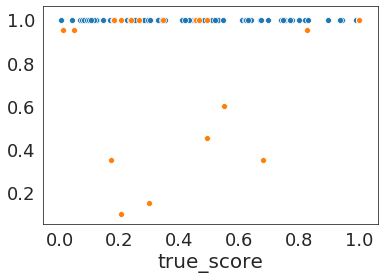

In [45]:
train_mask = y_train==1
test_mask = y_test==1
sns.scatterplot(y_train_continuous[train_mask], mean_train_prediction[train_mask])
sns.scatterplot(y_test_continuous[test_mask], mean_test_prediction[test_mask])
print(np.sum(mean_test_prediction[test_mask]<=0.1), np.sum(mean_test_prediction[test_mask]>=0.1))

243 78


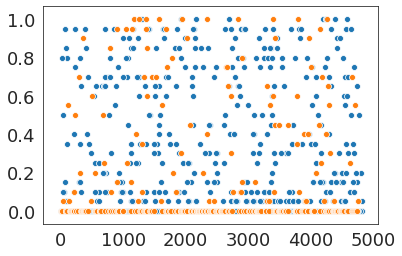

In [46]:
train_mask = y_train==0
test_mask = y_test==0
sns.scatterplot(y_train_continuous.index[train_mask], mean_train_prediction[train_mask])
sns.scatterplot(y_test_continuous.index[test_mask], mean_test_prediction[test_mask])
print(np.sum(mean_test_prediction[test_mask]<=0.1), np.sum(mean_test_prediction[test_mask]>0.1))

In [50]:
for thresh in np.linspace(0, 1, 21):
    tp = np.sum(mean_test_prediction[y_test==1]>=thresh)
    fn = np.sum(mean_test_prediction[y_test==1]<thresh)
    tn = np.sum(mean_test_prediction[y_test==0]<thresh)
    fp = np.sum(mean_test_prediction[y_test==0]>=thresh)
    beta = 1.0
    Fbeta = (1+beta**2)*tp/((1+beta**2)*tp+beta**2*fn + fp)
    print(thresh,Fbeta)
    beta = 2.0
    Fbeta = (1+beta**2)*tp/((1+beta**2)*tp+beta**2*fn + fp)
    print(thresh,Fbeta)    

0.0 0.12054794520547946
0.0 0.2552204176334107
0.05 0.30344827586206896
0.05 0.5213270142180095
0.1 0.33587786259541985
0.1 0.5583756345177665
0.15000000000000002 0.3448275862068966
0.15000000000000002 0.5494505494505495
0.2 0.3448275862068966
0.2 0.5494505494505495
0.25 0.36363636363636365
0.25 0.5681818181818182
0.30000000000000004 0.3883495145631068
0.30000000000000004 0.591715976331361
0.35000000000000003 0.36363636363636365
0.35000000000000003 0.5454545454545454
0.4 0.36363636363636365
0.4 0.5454545454545454
0.45 0.3829787234042553
0.45 0.5625
0.5 0.38636363636363635
0.5 0.551948051948052
0.55 0.3953488372093023
0.55 0.5592105263157895
0.6000000000000001 0.4266666666666667
0.6000000000000001 0.5673758865248227
0.65 0.4266666666666667
0.65 0.5673758865248227
0.7000000000000001 0.48484848484848486
0.7000000000000001 0.6060606060606061
0.75 0.48484848484848486
0.75 0.6060606060606061
0.8 0.5161290322580645
0.8 0.625
0.8500000000000001 0.5517241379310345
0.8500000000000001 0.645161290

In [55]:
thresh = 0.95
np.save('thresh.npy', thresh)

In [56]:
mean_train_prediction = mean_train_prediction>=thresh
mean_test_prediction = mean_test_prediction>=thresh

In [57]:
all_data['prettystring'] = all_data.apply(lambda x: '{} by {}'.format(x.title, x.author), axis=1)
prettystring = all_data.pop('prettystring')

In [58]:
y_train_comp = pd.DataFrame({'continuous': y_train_continuous, 'discrete': y_train, 'prediction': mean_train_prediction})
y_test_comp = pd.DataFrame({'continuous': y_test_continuous, 'discrete': y_test, 'prediction': mean_test_prediction})

In [59]:
prettystring.loc[y_train_comp.index[y_train_comp['discrete']!=y_train_comp['prediction']]]

1927                           Proxima by Stephen Baxter
1415                       The Heroes by Joe Abercrombie
2631                    The Peripheral by William Gibson
4587                            Turn Coat by Jim Butcher
3693                        Authority by Jeff VanderMeer
1858                    Oathbringer by Brandon Sanderson
1638                    Oathbringer by Brandon Sanderson
1152                 The Rithmatist by Brandon Sanderson
232                        Acceptance by Jeff VanderMeer
4574                  Terms of Enlistment by Marko Kloos
2172                 Kings of the Wyld by Nicholas Eames
1657                     Shades of Grey by Jasper Fforde
2890                   The Long Earth by Terry Pratchett
2732          The Bands of Mourning by Brandon Sanderson
3817                 Best Served Cold by Joe Abercrombie
2935             The Children of the Sky by Vernor Vinge
397                       Mes vrais enfants by Jo Walton
4194                          G

In [60]:
y_train_comp.loc[y_train_comp.index[y_train_comp['discrete']!=y_train_comp['prediction']]]

,continuous,discrete,prediction
1927,0.0,False,True
1415,0.0,False,True
2631,0.0,False,True
4587,0.0,False,True
3693,0.0,False,True
1858,0.0,False,True
1638,0.0,False,True
1152,0.0,False,True
232,0.0,False,True
4574,0.0,False,True


In [61]:
prettystring.loc[y_test_comp.index[y_test_comp['discrete']!=y_test_comp['prediction']]]

788                       Death's End by Liu Cixin
908                The Red Pyramid by Rick Riordan
989               Ready Player One by Ernest Cline
1046                Under the Dome by Stephen King
1141                  Red Sister by Mark  Lawrence
1167                     Walkaway by Cory Doctorow
1261      The Year of the Flood by Margaret Atwood
1362                  MaddAddam by Margaret Atwood
1363         Great North Road by Peter F. Hamilton
1582                Half a King by Joe Abercrombie
1686           Beren and Lúthien by J.R.R. Tolkien
1803       The Chaplain's War by Brad R. Torgersen
1950                     Walkaway by Cory Doctorow
2338              The Changeling by Victor LaValle
2790            A Memory of Light by Robert Jordan
2841                Zero History by William Gibson
2955                    Golden Son by Pierce Brown
3397          The Delirium Brief by Charles Stross
3807                 Spoonbenders by Daryl Gregory
3983                 Winter Tid

In [62]:
y_test_comp.loc[y_test_comp.index[y_test_comp['discrete']!=y_test_comp['prediction']]]

,continuous,discrete,prediction
788,0.679157,True,False
908,0.000000,False,True
989,0.550056,True,False
1046,0.000000,False,True
1141,0.000000,False,True
1167,0.000000,False,True
1261,0.000000,False,True
1362,0.000000,False,True
1363,0.000000,False,True
1582,0.000000,False,True


In [94]:
# Now try a regressor to rank things that were coded "winners"
x_train_regression = x_train[mean_train_prediction>0]
y_train_regression = y_train_continuous[mean_train_prediction>0]
x_test_regression = x_test[mean_test_prediction>0]
y_test_regression = y_test_continuous[mean_test_prediction>0]

In [115]:
if retrain:
    yp_train_regression_list = []
    yp_test_regression_list = []
    regression_model_list = []
    for i in range(10):
        xtr = x_train_regression.sample(frac=1, replace=True)
        ytr = y_train_regression[xtr.index]
        gbm = GradientBoostingRegressor(n_estimators=50)
        gbm.fit(xtr, ytr)
        yp_train_regression_list.append(gbm.predict(x_train_regression))
        yp_test_regression_list.append(gbm.predict(x_test_regression))
        regression_model_list.append(gbm)
        with open(f'gbm_regressor_ensemble_{i}.p', 'wb') as f:
            pickle.dump(gbm, f)
else:
    yp_train_regression_list = []
    yp_test_regression_list = []
    regression_model_list = []
    for i in range(10):
        with open(f'gbm_regressor_ensemble_{i}.p', 'rb') as f:
            regression_model_list.append(pickle.load(f))
        yp_train_regression_list.append(regression_model_list[-1].predict(x_train_regression))
        yp_test_regression_list.append(regression_model_list[-1].predict(x_test_regression))

In [ ]:
for i in range(10):
    with open(f'gbm_regressor_ensemble_{i}.p', 'wb') as f:
        pickle.dump(gbm, f)


In [116]:
mean_train_regression_prediction = np.mean(yp_train_regression_list, axis=0)
mean_test_regression_prediction = np.mean(yp_test_regression_list, axis=0)

Text(0, 0.5, 'Predicted score')

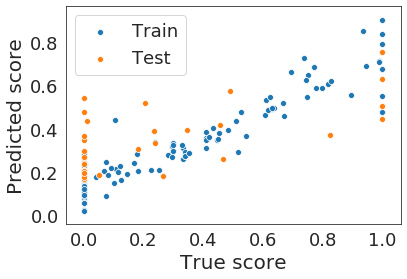

In [156]:
fig, ax = plt.subplots()
sns.scatterplot(y_train_regression, mean_train_regression_prediction, label="Train", ax=ax)
sns.scatterplot(y_test_regression, mean_test_regression_prediction, label="Test", ax=ax)
plt.xlabel("True score")
plt.ylabel("Predicted score")


In [118]:
from sklearn.metrics import r2_score
print(r2_score(np.concatenate([y_test_regression]), np.concatenate([mean_test_regression_prediction])))

0.2666910688968456


In [119]:
for i, model in enumerate(regression_model_list):
    with open(f'gbm_regressor_ensemble_{i}.p', 'wb') as f:
        pickle.dump(gbm, f)


In [120]:
x_train_regression_notselected = x_train[mean_train_prediction==0]
y_train_regression_notselected = y_train_continuous[mean_train_prediction==0]
x_test_regression_notselected = x_test[mean_test_prediction==0]
y_test_regression_notselected = y_test_continuous[mean_test_prediction==0]

In [121]:
yp_train_regression_notselected_list = []
yp_test_regression_notselected_list = []
for model in regression_model_list:
    yp_train_regression_notselected_list.append(model.predict(x_train_regression_notselected))
    yp_test_regression_notselected_list.append(model.predict(x_test_regression_notselected))


In [122]:
mean_train_regression_notselected_prediction = np.mean(yp_train_regression_notselected_list, axis=0)
mean_test_regression_notselected_prediction = np.mean(yp_test_regression_notselected_list, axis=0)

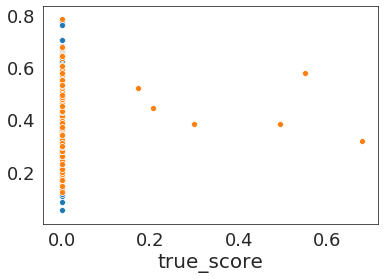

In [123]:
sns.scatterplot(y_train_regression_notselected, mean_train_regression_notselected_prediction)
sns.scatterplot(y_test_regression_notselected, mean_test_regression_notselected_prediction)

In [124]:
query = "SELECT * FROM works_withgenrelang"
all_data = pd.read_sql_query(query, con)

In [125]:
data, mask = make_regression_array(all_data, keep_short_stories = True)
all_data = all_data[mask]

0      -43.0
1      -44.0
3      -43.0
4      -39.0
5      -44.0
        ... 
4817   -48.0
4819   -47.0
4821   -45.0
4824   -42.0
4825   -41.0
Name: debut_year, Length: 2899, dtype: float64


/home/msimet/projects/victor_predictor/analysis/notebooks/utils.py:26: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  year_mask = (data['debut_year'].isna()) | (data['pub_date']>=datetime.date(2030, 1, 1)) | (data['pub_date'].isna())
/home/msimet/projects/victor_predictor/analysis/notebooks/utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['debut_year'][year_mask] = np.nan
/home/msimet/projects/victor_predictor/analysis/notebooks/utils.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [126]:
data = data[cols].drop(columns='true_score')

In [127]:
yc_list = []
for model in model_list:
    yc_list.append(model.predict(data))
nominee = np.mean(yc_list, axis=0)>=thresh

ys_list = []
for model in regression_model_list:
    ys_list.append(model.predict(data))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

In [128]:
print(score[yes_mask].min(), score[yes_mask].max(), score[~yes_mask].min(), score[~yes_mask].max())

0.5 1.0 0.0 0.5


In [129]:
all_data['pred_score'] = score

In [131]:
def make_datasets_readinglevel(data):
    tdata = data.copy()
    res = []
    for ya in [data['ya'].min(), data['ya'].max()]:
        for children in [data['children'].min(), data['children'].max()]:
            tdata['ya'] = ya
            tdata['children'] = children
            yield tdata

def make_datasets_author(data):
    tdata = data.copy()
    for aviews in np.linspace(
            data['author_annualviews'].min(), data['author_annualviews'].max(), 10):
        for nprev in range(max(data['nprev'])//2):
            tdata['author_annualviews'] = aviews
            tdata['nprev'] = nprev
            yield tdata


In [132]:
# Marginalize over reading level
yc_list = []
for tdata in make_datasets_readinglevel(data):
    for model in model_list:
        yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.1

ys_list = []
for tdata in make_datasets_readinglevel(data):
    for model in regression_model_list:
        ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_readinglevel'] = score

In [134]:
# Marginalize over authorship
yc_list = []
for tdata in make_datasets_author(data):
    for model in model_list:
        yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.1

ys_list = []
for tdata in make_datasets_author(data):
    for model in regression_model_list:
        ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_author'] = score

In [135]:
# Marginalize over reading level and authorship
yc_list = []
for ttdata in make_datasets_readinglevel(data):
    for tdata in make_datasets_author(ttdata):
        for model in model_list:
            yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0) > 0.2

ys_list = []
for ttdata in make_datasets_readinglevel(data):
    for tdata in make_datasets_author(ttdata):
        for model in regression_model_list:
            ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_readinglevel_author'] = score

In [136]:
all_data = all_data.drop(columns=['level_0', 'index'])

In [137]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name))

In [138]:
genre_data = all_data[[col for col in all_data.columns if col[:5]=='genre']]

In [139]:
genre_min = np.min(genre_data, axis=1)

In [140]:
genre_min.shape

(4686,)

In [141]:
genre_cutoff = genre_min+0.1

In [142]:
genre_cutoff[(genre_cutoff>=0.5) & (genre_cutoff<=0.6)] = 0.5

In [149]:
genre_cutoff[genre_cutoff>=0.6] = genre_min[genre_cutoff>=0.6]

In [150]:
genre_data = genre_data<=genre_cutoff[:,None]

In [151]:
np.sum(genre_data, axis=1).value_counts()

2    1184
3     891
9     615
8     406
7     357
1     338
4     286
5     279
6     245
0      85
dtype: int64

In [152]:
for i in range(10):
    all_data['is_genre{}'.format(i)] = genre_data['genre{}'.format(i)]

In [153]:
all_data.to_sql('works_flask', engine) 

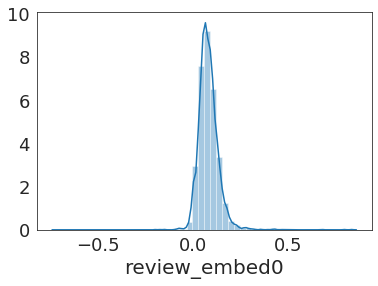

In [160]:
sns.distplot(all_data['review_embed0'])

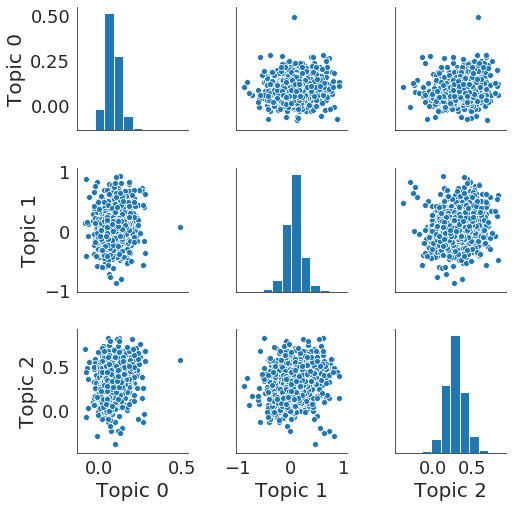

In [178]:
cols = ['review_embed0', 'review_embed1', 'review_embed2']
tdata = all_data
for col in cols:
    tdata = tdata[tdata[col]!=0]
    tdata = tdata[~(tdata[col].isna())]
for i in range(len(cols)):
    tdata = tdata.rename(columns={'review_embed{}'.format(i): 'Topic {}'.format(i)})
sns.pairplot(tdata[['Topic {}'.format(i) for i in range(len(cols))]])